## Augmentation을 활용한 모델 성능 향상

### 학습 목표
- Augmentation을 모델 학습에 적용하기
- Augmentation의 적용을 통한 학습 효과 확인하기
- 최신 data augmentation 기법 구현 및 활용하기

### 루브릭 
- CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? : **CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.**
- 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? : **Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함**
- 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? : **기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.**


## 목차
### 0. 환경 설정
### 1. Augmentation을 적용한 데이터셋 만들기
#### 1) 데이터 로드
#### 2) Cutmix Augmentation
#### 3) Mixup Augmentation
#### 4) 데이터셋 만들기
### 2. 모델 성능 비교
#### 1) 모델 구성 및 훈련
#### 2) 각 데이터셋에 대한 결과 비교
---

### 0. 환경 설정

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

folder = 'Colab Notebooks'
project_dir = 'going_deeper_CV'

base_path = Path('/content/gdrive/My Drive')
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
  if x.is_dir():
    dir_name = str(x.relative_to(project_path))
    os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f'현재 디렉토리 위치: {os.getcwd()}')

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/going_deeper_CV


In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 이용한 데이터셋 만들기

#### 1) 데이터 로드 및 정규화

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train','test'],
    as_supervised=True,
    shuffle_files=True, 
    with_info=True, 
    data_dir=os.getcwd()+'/datasets'
    )

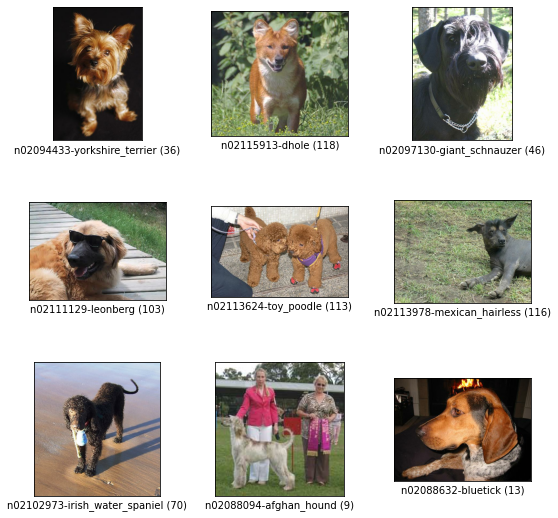

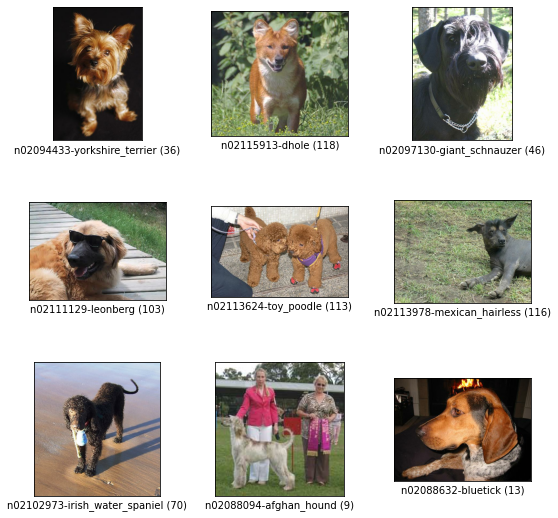

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [ ]:
num_classes = ds_info.features['label'].num_classes

In [ ]:
def normalize_and_resize_img(image, label):
  image = tf.image.resize(image, [224,224])
  return tf.cast(image, tf.float32) / 255., label    # float 형태이므로 int인 255로 나누면 오류가 발생한다.

* `tf.cast(tensor, dtype)`: 텐서를 새로운 자료형`dtype`으로 변환

In [ ]:
def apply_normalize_on_dataset(ds, batch_size=16, is_test=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )

  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [ ]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

#### 2) Cutmix Augmentation
이미지를 잘라 붙여 새 이미지를 만들고, 섞은 이미지에 맞추어 라벨도 함께 섞어 붙이는 방법

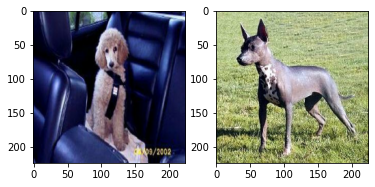

In [ ]:
for i, (image, label) in enumerate(ds_train.take(1)):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

1. 첫 번째 이미지 a를 바탕으로, 두 번째 이미지 b를 삽입할 이미지로 가정하고, a에 삽입될 영역의 바운딩 박스 위치를 결정하는 함수 선언

In [ ]:
def get_clip_box(image_a, image_b):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]

  # [0,image_size_x), [0, image_size_y) 범위에서 임의의 정수값을 x,y에 저장
  x = tf.cast(tf.random.uniform([],0,image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([],0,image_size_y), tf.int32)

  # image_size_x, image_size_y보다 적은 정수값 width, height에 저장 
  width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
  height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)

  # (x,y)를 중심으로 width, height를 갖는 clip box의 네 꼭지점 선언(image_b가 들어갈 공간)
  x_min = tf.math.maximum(0, x-width//2)
  y_min = tf.math.maximum(0, y-height//2)
  x_max = tf.math.minimum(image_size_x, x+width//2)
  y_max = tf.math.minimum(image_size_y, y+width//2)

  return x_min, y_min, x_max, y_max

In [ ]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x: ', x_min, x_max)
print('y: ', y_min, y_max)

x:  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(116, shape=(), dtype=int32)
y:  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(136, shape=(), dtype=int32)


2. image_a에서 clip box의 바깥쪽, image_b에서 clip box의 안쪽 영역을 가져와서 합치는 함수 선언

In [ ]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]
  middle_left = image_a[y_min:y_max, 0:x_min, :]
  middle_center = image_b[y_min:y_max, x_min:x_max, :]
  middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
  middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
  top = image_a[0:y_min,:,:]
  bottom = image_a[y_max:image_size_y,:,:]
  mixed_img = tf.concat([top, middle, bottom], axis = 0)

  return mixed_img

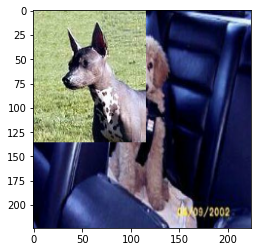

In [ ]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

3. 면적에 비례해서 라벨을 섞는 함수 선언

In [ ]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes):
  image_size_x = image_a.shape[1]
  image_size_y = image_b.shape[0]

  mixed_area = (x_max-x_min)*(y_max-y_min)
  total_area = image_size_x*image_size_y

  ratio = tf.cast(mixed_area/total_area, tf.float32)

  if len(label_a.shape)==0:
    label_a = tf.one_hot(label_a, num_classes)
  if len(label_b.shape)==0:
    label_b = tf.one_hot(label_b, num_classes)
  mixed_label = (1-ratio)*label_a + ratio*label_b

  return mixed_label

In [ ]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

4. 배치 단위로 이미지를 섞고, 라벨을 섞는 함수 구현

In [ ]:
def cutmix(image, label, batch_size=16, img_size=224, num_classes=120):
  mixed_imgs = []
  mixed_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]

    j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)    # 임의의 image_b 선정
    image_b = image[j]
    label_b = label[j]

    x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
    mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
    mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

  mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
  mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

  return mixed_imgs, mixed_labels

#### 3) Mixup Augmentation

In [ ]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

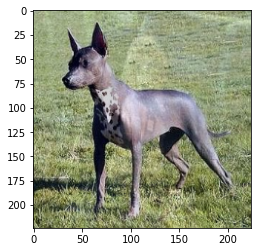

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [ ]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [104]:
def onehot(image,label, batch_size=16, img_size = 224, num_classes=120):
  imgs=[]
  labels=[]
  for i in range(batch_size):
    imgs.append(image[i])
    labels.append(tf.one_hot(label[i],num_classes))
  
  imgs = tf.reshape(tf.stack(imgs), (batch_size, img_size, img_size, 3))
  labels = tf.reshape(tf.stack(labels), (batch_size, num_classes))

  return imgs, labels

#### 4) 데이터셋 만들기

In [75]:
# 기본 augment 기법
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image,0,1)
  return image, label

In [123]:
def apply_normalize_and_augment_on_dataset(ds, batch_size=16, is_test=False, with_aug = False, with_cutmix=False, with_mixup=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )

  if not is_test and with_aug:
    ds = ds.map(augment)
  
  ds = ds.batch(batch_size)

  if is_test and (with_cutmix or with_mixup):
    ds = ds.map(
        onehot,
        num_parallel_calls=2
        )
  if not is_test and with_cutmix:
    ds = ds.map(
        cutmix,
        num_parallel_calls=2
        ) 
  if not is_test and with_mixup:
    ds = ds.map(
        mixup,
        num_parallel_calls=2
        )
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [124]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train','test'],
    as_supervised=True,
    shuffle_files=True, 
    with_info=True, 
    data_dir=os.getcwd()+'/datasets'
    )

ds_train_cutmix = apply_normalize_and_augment_on_dataset(ds_train, batch_size=16, is_test=False, with_aug = True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_and_augment_on_dataset(ds_train, batch_size=16, is_test=False, with_aug = True, with_cutmix=False, with_mixup=True)
ds_train_aug = apply_normalize_and_augment_on_dataset(ds_train, batch_size=16, is_test=False, with_aug = True, with_cutmix=False, with_mixup=False)
ds_train = apply_normalize_and_augment_on_dataset(ds_train, batch_size=16, is_test=False, with_aug = False, with_cutmix=False, with_mixup=False)
ds_test = apply_normalize_and_augment_on_dataset(ds_test, batch_size=16, is_test=True, with_aug = False, with_cutmix=False, with_mixup=False)
ds_test_mix = apply_normalize_and_augment_on_dataset(ds_test, batch_size=16, is_test=True, with_aug = False, with_cutmix=False, with_mixup=True)

In [108]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [109]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [110]:
ds_train_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [125]:
ds_test_mix

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

In [122]:
ds_train_cutmix

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

In [113]:
ds_train_mixup

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

### 2. 모델 성능 비교

#### 1) 모델 구성 및 훈련
keras에서 imagenet으로 미리 훈련된 모델(ResNet50)을 불러오되, 사용할 데이터셋이 imagenet과 다른 클래스를 가지므로, 마지막 fully connected layer는 불러오지 않고 추후에 수정된 fully connected layer를 붙인다. 즉, 훈련된 ResNet50을 불러오되 '특성 추출' 부분만 가지고 오는 셈이다.    
augmentation을 적용한 데이터셋으로 학습시킬 모델과 그렇지 않은 모델 두 가지를 만든다.

In [ ]:
resnet50 = keras.models.Sequential([
                                    keras.applications.resnet.ResNet50(
                                        include_top = False,    # fully connected layer 부르지 않음
                                        weights = 'imagenet',
                                        input_shape = (224,224,3),    # 전처리 완료한 shape
                                        pooling = 'avg'
                                        ),
                                    keras.layers.Dense(num_classes, activation = 'softmax')    # 사용할 데이터셋에 맞는 fully connected layer 추가
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
aug_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
mixup_resnet50  = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
EPOCH = 20

In [87]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [88]:
history_resnet50_no_aug = resnet50.fit(
    ds_train, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 111s 137ms/step - loss: 2.1673 - accuracy: 0.4566 - val_loss: 3.3521 - val_accuracy: 0.2134
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.6796 - accuracy: 0.8196 - val_loss: 1.0851 - val_accuracy: 0.6814
Epoch 3/20
750/750 [==============================] - 93s 124ms/step - loss: 0.1848 - accuracy: 0.9673 - val_loss: 0.9458 - val_accuracy: 0.7207
Epoch 4/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0490 - accuracy: 0.9962 - val_loss: 0.8937 - val_accuracy: 0.7390
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0205 - accuracy: 0.9997 - val_loss: 0.9094 - val_accuracy: 0.7406
Epoch 6/20
750/750 [==============================] - 94s 125ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9207 - val_accuracy: 0.7403
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9318 - val_a

In [89]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [90]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 122ms/step - loss: 2.3029 - accuracy: 0.4224 - val_loss: 2.9349 - val_accuracy: 0.2695
Epoch 2/20
750/750 [==============================] - 95s 127ms/step - loss: 0.9454 - accuracy: 0.7309 - val_loss: 1.4042 - val_accuracy: 0.6051
Epoch 3/20
750/750 [==============================] - 90s 120ms/step - loss: 0.5602 - accuracy: 0.8428 - val_loss: 1.1232 - val_accuracy: 0.6758
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.2755 - accuracy: 0.9335 - val_loss: 1.0360 - val_accuracy: 0.6981
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1414 - accuracy: 0.9722 - val_loss: 0.9599 - val_accuracy: 0.7261
Epoch 6/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0808 - accuracy: 0.9866 - val_loss: 0.9432 - val_accuracy: 0.7326
Epoch 7/20
750/750 [==============================] - 95s 126ms/step - loss: 0.0475 - accuracy: 0.9935 - val_loss: 0.9441 - val_a

In [91]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_mix,
    verbose=1,
    use_multiprocessing=True,
)

In [92]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
